### Import libraries

In [26]:
import sys
sys.path.append("..")
import os
from model import experimental_model, experimental2d_model, grapher, exp2d_model_tr
from data import batch_creator, loader, data_generation
from helpers import helpers, plotter, metrics
import tensorflow as tf
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
import itertools

In [29]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
kernel = "botswana"
d = True

In [5]:
botswana = np.load("/Users/omernivron/Downloads/GFDL_botswana.npy")

In [6]:
bots_dim = np.load("/Users/omernivron/Downloads/GFDL_botswana_dimensions.npy")

In [7]:
bots_t = np.load("/Users/omernivron/Downloads/GFDL_botswana_times.npy")

In [8]:
bots_loc =  np.load("/Users/omernivron/Downloads/GFDL_botswana_lat_lon.npy")

In [9]:
bots_win = np.load("/Users/omernivron/Downloads/GFDL_within_bots_lat_lon.npy")

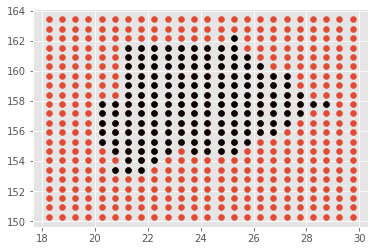

In [25]:
# plt.scatter(bots_loc[:, 1], bots_loc[:, 0], c=botswana[0, :, 500], cmap="seismic")
# plt.colorbar()
plt.scatter(bots_loc[:, 1], bots_loc[:, 0])
plt.scatter(bots_win[:, 1], bots_win[:, 0], c='black')

In [11]:
save_dir = os.path.expanduser('~/Downloads/' + kernel)

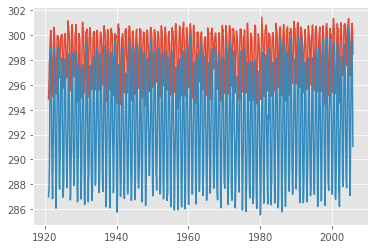

In [12]:
fig,ax = plt.subplots()
ax.plot(bots_t, botswana[1, 0, :])
ax.plot(bots_t, botswana[1, 470, :])

In [13]:
y = botswana

In [14]:
n = y.shape[0]

In [15]:
combos = list(itertools.combinations(np.arange(n), 2))

In [16]:
data = [np.concatenate((botswana[pair[0]].reshape(528, -1), botswana[pair[1]].reshape(528, -1)), axis = -1) if (pair[1] < 30) else np.zeros((528, 2040)) for pair in combos]

In [17]:
t = np.concatenate((bots_t, bots_t))
t = t - np.mean(t)

In [18]:
y =data

In [19]:
d_y = np.array([np.concatenate((y[i][:, j:j+205], y[i][:, 1020+j:1225 +j]), axis = -1) for i in range(len(y)) for j in range(0, 815, 163) ])
t_y = np.array([np.concatenate((t[j:j+205], t[1020+j:1225 +j])) for i in range(len(y)) for j in range(0, 815, 163)])


In [20]:
μ = np.mean(y)
d_y = d_y - μ

In [21]:
d_y1 = d_y[:500, :, :]

In [22]:
d_y1.shape

(500, 528, 410)

In [21]:
def embed_position(t, d, TΔmin, Tmax):  # return.shape=(T,B,d)
    # t.shape=(T,B)   T=sequence_length, B=batch_size
    """A position-embedder, similar to the Attention paper, but tweaked to account for
    floating point positions, rather than integer.
    """
    R = Tmax / TΔmin * 100
    drange_even = TΔmin * R**(np.arange(0,d,2)/d)
    drange_odd = TΔmin * R**((np.arange(1,d,2) - 1)/d)
    x = np.concatenate([np.sin(t[:,:,None] / drange_even), np.cos(t[:,:,None] / drange_odd)], 2)
    return x

In [22]:
k = np.concatenate([np.zeros(205, dtype=int), np.ones(205, dtype=int)])

In [23]:
x1 = np.array([embed_position((t_y[i, :])[:, None], d=44, TΔmin= 0.8, Tmax=200) for i in range(len(t_y[:500, :]))])

In [24]:
x1.shape

(500, 410, 1, 44)

In [25]:
x2 = np.repeat(tf.one_hot(k, 2)[None, :, None, :],  500, axis =0)

In [26]:
bots_loc = bots_loc[None, :, None, :]

In [27]:
bots_loc = np.repeat(bots_loc,  500, axis =0)

In [28]:
bots_loc = np.repeat(bots_loc,  410, axis =2)

In [29]:
bots_loc.shape

(500, 528, 410, 2)

In [30]:
x = np.concatenate((x1, x2), axis =-1).squeeze()

In [31]:
x = x[:, None, :, :]

In [32]:
x.shape

(500, 1, 410, 46)

NameError: name 'd_y1' is not defined

In [33]:
(x.size * x.itemsize) / 1048576

71.9451904296875

In [34]:
x = np.repeat(x, 528, axis =1)

In [ ]:
zz = x[:, :, :290, :].reshape(500, -1, 46)

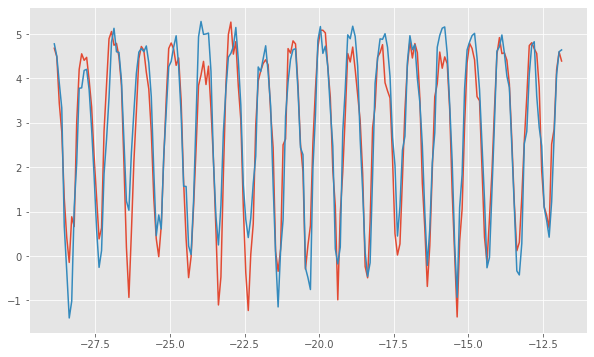

In [39]:
cmap = plt.get_cmap('Paired', 2)

fig,ax = plt.subplots(figsize=(10, 6))
ax.plot(t_y[261, :205], d_y[261,1, :205])
ax.plot(t_y[261, 205:], d_y[261,1, 205:])
# ax.plot(t_y[3, :205], d_y[3,1, :205])
# ax.plot(t_y[3, 205:], d_y[3,1, 205:])
plt.show()

In [40]:
train_step, test_step, train_loss, test_loss, m_tr, m_te = grapher.build_graph()

In [ ]:
# b_data = batch_creator.create_batch(em_x = data[1], em_y=data[3], x = data[5], y = data[-1], batch_s=2, d=d)
# b_data_te = b_data

In [ ]:
# Uncomment the two lines below for one batch to overfit on
# np.random.seed(443)
# b_data, c = batch_creator.create_batch_2d(data[2], data[-3], data[-1], batch_s=20, em_2 = data[3])

### Training

In [ ]:
if __name__ == '__main__':
    step = 0
    # change to run 9 if you want to overfit
    EPOCHS = 575; batch_s  = 32; run = 1; tr_regime ='shuffle'
    l= [48, 32, 32]; heads = 12; e = 48; context = 290; c=290
    name_comp = 'run_' + str(run)
    logdir = save_dir + '/logs/' + name_comp
    writer = tf.summary.create_file_writer(logdir)
    folder = save_dir + '/ckpt/check_' + name_comp
    optimizer_c = tf.keras.optimizers.Adam(3e-4)
    helpers.mkdir(folder)
    decoder = exp2d_model_tr.Decoder(e, l[0], l[1], l[2], num_heads=heads)
    num_batches = int(x.shape[0] / batch_s)
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer_c, net=decoder)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
    with writer.as_default():
        for epoch in range(EPOCHS):
            start = time.time()
            for batch_n in range(100):
                m_tr.reset_states(); train_loss.reset_states()
                if d:
                    idxs = np.random.choice(np.arange(420), 32)
                    permute_idx = np.arange(410)
                    y_tr = aa[idxs, :][:, permute_idx] 
                    x_tr = x[idxs, :, :]
                    to_gather = helpers.gather_idx(c,  l=410, b=32)
                    temp = np.zeros((32, 410))
                    temp[to_gather[:, 0], to_gather[:, 1]] = 1
#                   b_data, c = batch_creator.batch_regime_2d(x = data[-3], y = data[-1], em = data[2] , em_2 =  data[3], batch_s=64, context_p=50, kind='shuffle')
                    # add parameter b=20 to helpers.gather_idx if you want to overfit and comment line above
                    pred, pred_log, weights, names, shapes, y_real, g = train_step(decoder, optimizer_c, train_loss, m_tr, x_tr, y_tr, d = True, to_gather=temp)
                else:
#                     b_data = batch_creator.create_batch(em_x = data[1], x = data[3], y = data[-1], batch_s=64, d=d)
                    to_gather = helpers.gather_idx(context, l=200, b=2)
                    temp = np.zeros((b_data[0].shape[0], b_data[0].shape[1]))
                    temp[to_gather[:, 0], to_gather[:, 1]] = 1
                    pred, pred_log, weights, names, shapes, y_real, g = train_step(decoder, optimizer_c, train_loss, m_tr, x = b_data[2], y = b_data[0], y2=b_data[3], to_gather = temp)
                if (epoch == 0) & (batch_n == 0): helpers.write_speci(folder, names, shapes, context, heads)
                if batch_n % 1 == 0:
                    m_te.reset_states(); test_loss.reset_states()
                    if d:
                        idxs_te = np.random.choice(np.arange(420, 500), 32)
                        permute_idx_te = np.arange(410)
                        to_gather_te = helpers.gather_idx(c, l=410, b=32)
                        temp_te = np.zeros((32, 410))
                        temp_te[to_gather_te[:, 0], to_gather_te[:, 1]] = 1
                        y_te = aa[idxs_te, :][:, permute_idx_te] 
                        x_te = x[idxs_te, :, :]
                        pred_te, pred_log_te = test_step(decoder, test_loss, m_te, x_te = x_te, y_te = y_te, to_gather=temp_te, d=True)
                        fig,ax = plt.subplots()
                        
                        ax.plot(t_yy[idxs_te[1], 70:] , y_te[1][70:], c='blue')
                        ax.plot(t_yy[idxs_te[1], :50], y_te[1][:50], c='red')
                        ax.plot(t_yy[idxs_te[1], 50:70], y_te[1][50:70], c='red')
                        ax.plot(t_yy[idxs_te[1], 70:], pred_te[1, 69:], c='goldenrod') 
                        plt.show()
                        
                        
                        
#                         b_data_te, c_te = batch_creator.batch_regime_2d(x = data[-4], y = data[-2], em = data[0] , em_2 =  data[1], batch_s=64, context_p=context, kind=tr_regime)
#                         to_gather_te = helpers.gather_idx(c_te)
#                         temp_te = np.zeros((b_data_te[0].shape[0], b_data_te[0].shape[1]))
#                         temp_te[to_gather_te[:, 0], to_gather_te[:, 1]] = 1
#                         pred_te, pred_log_te = test_step(decoder, test_loss, m_te, x_te = b_data_te[2], y_te = b_data_te[0], x2_te = b_data_te[3], to_gather=temp_te, d=True)
#                         ## Plotting progress by looking at a random test case. Erase _te from the six lines below if you rather observe training

#                         if to_gather_te is not None:
#                             # change 64 to 20 if you are overfitting
#                             idd = np.random.choice(np.arange(0, 64))
#                             seq_l = to_gather_te[to_gather_te[:, 0] == idd][0, 1]
#                             plt.scatter(b_data_te[1][idd, :seq_l], b_data_te[0][idd, :seq_l] , c = 'blue', label = 'context')
#                             plt.scatter(b_data_te[1][idd, seq_l:], b_data_te[0][idd, seq_l:], c = 'black', label = 'observed func.', alpha=0.5)
#                             plt.scatter(b_data_te[1][idd, seq_l:], pred_te[idd][(seq_l - 1):], label = 'predicted func.')
#                             plt.legend()
#                             plt.show()
#                         else:
#                             plotter.follow_training_plot2d(x_tr = b_data[1], y_tr = b_data[0], em_2_tr = b_data[3] , pred = pred, x_te = b_data_te[2], y_te = b_data_te[0], em_2_te = b_data_te[3] ,pred_te = pred_te, num_context = context)
                    else:
                        pred_te, pred_log_te = test_step(decoder, test_loss, m_te, x_te = b_data_te[2], y_te = b_data_te[0], y2_te=b_data_te[3], to_gather = temp)
                        plotter.follow_training_plot(x_tr = b_data[1], y_tr = b_data[0], pred = pred, x_te = b_data_te[2], y_te = b_data_te[0], pred_te = pred_te, num_context = context)
                    helpers.print_progress(epoch, batch_n, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result())
                    helpers.tf_summaries(run, step, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result(), weights, names)
                    print('learning rate is {}'.format(optimizer_c._decayed_lr('float32').numpy()))
#                     if d:
#                         m0, m1 = metrics.r_sq_2d(b_data[0][:, 1:], pred.numpy(), b_data[3][:, 1:], context_p = context)
#                         m0_te, m1_te = metrics.r_sq_2d(b_data_te[0][:, 1:], pred_te.numpy(), b_data_te[3][:, 1:], context_p = context)
#                         print('r squared training, series 0: {}, series 1: {}'.format(m0, m1))
#                         print('r squared testing, series 0: {}, series 1: {}'.format(m0_te, m1_te))
                    manager.save()
                step += 1
                ckpt.step.assign_add(1)
            print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

### Embeddings in tensorboard

In [ ]:
helpers.tensorboard_embeddings(decoder, layer_num = 0, meta_data = np.concatenate(([0, 1], np.unique(b_data[2]))))

In [ ]:
y_s = aa[idd, :70] 

In [ ]:
aa[1, :].shape

In [ ]:
idd[0]

In [ ]:
y_tr.shape

In [ ]:
aa.max()

### Inference

In [ ]:
idd = np.random.choice(np.arange(4000, 4877), 1)[0]
fig,ax = plt.subplots()
for j in range(100):
    y_s = aa[idd, :70] 
    y_s = y_s[:-1][None, :]
    for i in range(29):
        x_s = x[idd, :(70 + i), :][None, :, :]
        _, _, sample_y = evaluate(decoder, x_s, y_s, d=d, sample=True)
        y_s = tf.concat((y_s, tf.reshape(sample_y, [1, 1])), axis=1)
    ax.plot(t_yy[idd, :50], aa[idd][:50], c='red')
    ax.plot(t_yy[idd, 50:70], aa[idd][50:70], c='red')
    
    ax.plot(t_yy[idd, 70:-1], (y_s.numpy()[:, 69:].reshape(-1)), c='lightblue')
y_s = aa[idd, :70] 
y_s = y_s[:-1][None, :]
for i in range(29):
    x_s = x[idd, :(70 + i), :][None, :, :]
    _, _, sample_y = evaluate(decoder, x_s, y_s, d=d, sample=False)
    y_s = tf.concat((y_s, tf.reshape(sample_y, [1, 1])), axis=1)
ax.plot(t_yy[idd, :50], aa[idd][:50], c='red')
ax.plot(t_yy[idd, 50:70], aa[idd][50:70], c='red')
ax.plot(t_yy[idd, 70:-1], (y_s.numpy()[:, 69:].reshape(-1)), c='goldenrod')
ax.plot(t_yy[idd, 70:], aa[idd][70:], c='blue')

In [ ]:
def evaluate(model, x, y, sample=True, d=False):

    combined_mask_x = masks.create_masks(x[:, :, 0])
    pred = model(x, y, False, combined_mask_x[:, :-1, :-1])
    if sample:
        sample_y = np.random.normal(pred[-1, 0], np.exp(pred[-1, 1]))
    else:
        sample_y = pred[-1, 0]

    return pred[:, 0], pred[:, 1], sample_y

In [ ]:
from helpers import masks